# ASTR597b HW1 
## Matt Wilde
#### Due: Feb 16th 2015



## Problem 1: Querying and data analysis with SDSS

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import sqlite3

In [2]:
#older version of astropy didnt have to_pandas()
import astropy
print astropy.__version__

1.1.1


** 1) Use the schema browser to familiarize yourself with the contents of a view named Star. Then:**
* **Write (and execute) an SQL query to count how many stars have been observed with SDSS (in the current Data Release 12).**

    select
      COUNT(s.objid)

    from
      Star s

    into
      mydb.HowManyStars
      
With result:
    260562744

* **Write (and execute) an SQL query to count how many observations there are in u, g, r, i and z bands, and the average observed magnitude in each band. How does the SDSS database record missing (magnitude) data?**

Bad photometric data is recorded as -9999.

SQL Query:
```      
SELECT
  COUNT(dered_u) as count_u,
  COUNT(dered_g) as count_g, 
  COUNT(dered_r) as count_r,
  COUNT(dered_i) as count_i,
  COUNT(dered_z) as count_z,
  AVG(dered_u) as mean_u,
  AVG(dered_g) as mean_g,
  AVG(dered_r) as mean_r,
  AVG(dered_i) as mean_i,
  AVG(dered_z) as mean_z
  
FROM
  Star

WHERE
  u > -9999 and g > -9999 and r > -9999 and i > -9999 and z > -9999
  
INTO
  mydb.UGRIZcounts
```

In [3]:
ugriz_counts = Table.read('../../../hw1data/UGRIZcounts_mwilde.fit')
ugriz_counts

count_u,count_g,count_r,count_i,count_z,mean_u,mean_g,mean_r,mean_i,mean_z
int32,int32,int32,int32,int32,float64,float64,float64,float64,float64
260556474,260556474,260556474,260556474,260556474,21.7545962171,21.0579618634,20.2939945699,19.7679934991,19.4326922088


Make a plot just for fun.

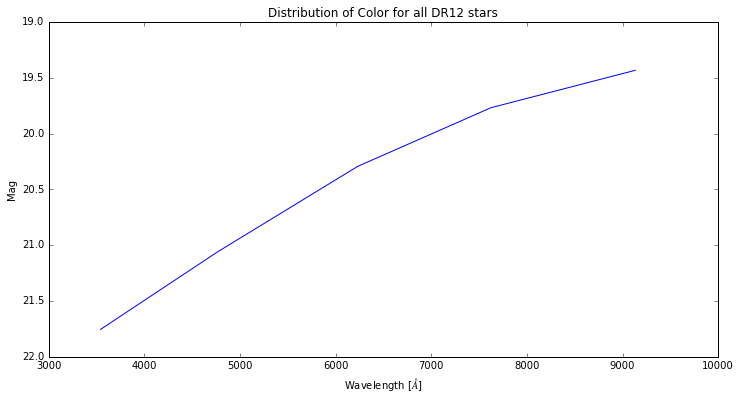

In [4]:
fig, ax = plt.subplots(figsize=(12,6))
y = (ugriz_counts['mean_u'], ugriz_counts['mean_g'], ugriz_counts['mean_r'], ugriz_counts['mean_i'], ugriz_counts['mean_z'])
x = [3543, 4770, 6231, 7625, 9134]

ax.plot(x,y)
ax.set_title('Distribution of Color for all DR12 stars')
ax.set_ylabel('Mag')
ax.set_xlabel(r'Wavelength [$\AA$]')
ax.invert_yaxis()

**2.) Write an SQL query to select the positions ($\alpha$, also known as `ra`, and $\delta$, also know as `dec`) and the extinction-corrected (a.k.a. *dereddened*) `g` and `r`-band magnitudes of all stars bounded by $225 < \alpha < 235$ and $-2.5 < \delta < 4$. Your query should store the outputs into a temporary table in MyDB. Download it as a FITS file. Use the `astropy.tables` module to load the table data into Python, then store it into a local sqlite database (using `Pandas` to_sql() functions).**

In [5]:
t2 = Table.read('../../../hw1data/hw1_task2_mwilde.fit')
t2[:5]

ra,dec,dered_r,dered_g
float64,float64,float32,float32
226.860713994,-1.2031605343,23.8041,25.5259
226.860373412,-1.16042546622,21.8844,22.758
226.861989841,-1.16046981925,16.7331,17.6833
226.857509957,-1.0799896095,18.2503,18.7599
226.732616872,-1.08120314257,18.2391,18.8677


In [6]:
pdt2 = t2.to_pandas()
pdt2[:5]

,ra,dec,dered_r,dered_g
0,226.860714,-1.203161,23.804127,25.525900
1,226.860373,-1.160425,21.884378,22.757977
2,226.861990,-1.160470,16.733147,17.683302
3,226.857510,-1.079990,18.250273,18.759899
4,226.732617,-1.081203,18.239143,18.867737


make sure we are starting from scratch by erasing existing msdss:

In [7]:
import os
try:
    os.remove("../../../hw1data/msdss.db")
except OSError:
    pass

create and connect sqlite3 to our database

In [8]:
con = sqlite3.connect("../../../hw1data/msdss.db")

put our sdss star data into it:

In [9]:
pdt2.to_sql('t2_sql',con)

In [10]:
con.close()

**3. In an IPython notebook, make an $ra$ vs $dec$ scatter plot of the data. Note that the right ascension by convention increases from right to left; make sure your plot reflects that. What do you see near $\alpha \sim 229$ and $\delta \sim 0$? Do know what is this object?**

In [11]:
import matplotlib as mpl

plt.rc('font', family='serif', size=15)
#mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

#use the pretty LaTeX fonts
mpl.rcParams.update({'text.usetex': True})

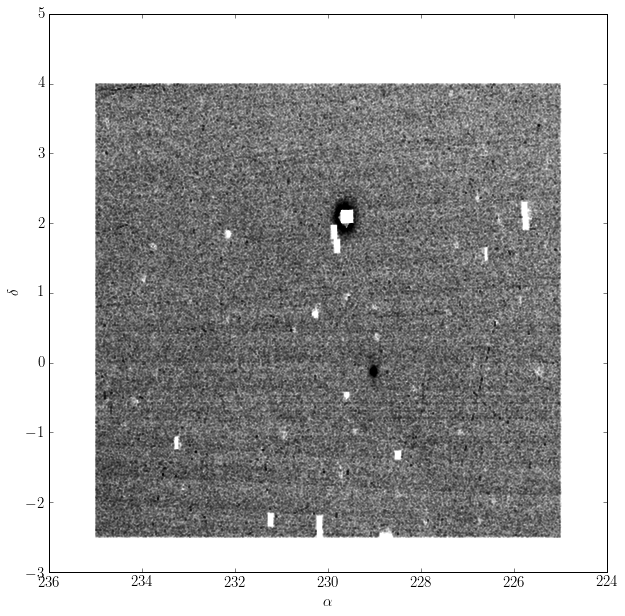

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(t2['ra'], t2['dec'], marker='.', s=0.01)
ax.invert_xaxis()

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')

The object could be a globular cluster or dwarf galaxy being stripped by the Milky Way.

**4. Select a subset of the data in a region (a rectangle is fine!) tightly bounding the observed object. Select data in another, equally sized region, nearby but *away* from the object. Do the selection in two ways: with an SQL query of your local sqlite database, and using the indexing operators in Python (the square brackets '[]'). Show that the two give identical results (it's sufficient to show they return the same number of rows for the same constraints).**

Method 1) SQL query of the local sqlite database msdss.db

In [13]:
con = sqlite3.connect('../../../hw1data/msdss.db')
c = con.cursor()

In [14]:
subsec1 = pd.read_sql("""
    SELECT
        ra,
        dec,
        dered_r,
        dered_g
    FROM
        t2_sql
    WHERE
        ra < 229.15 and ra > 228.9 and dec < -0.01 and dec > -0.22
""", con)

In [15]:
subsec2 = pd.read_sql("""
SELECT
    ra,
    dec,
    dered_r,
    dered_g
FROM
    t2_sql
WHERE
    ra < 228.25 and ra > 228.0 and dec > 0.01 and dec < 0.22
""", con)

In [16]:
print len(subsec1)
print len(subsec2)

2492
1007


Now do it the python way:

In [17]:
select_GC = t2[(t2['ra'] < 229.15) & (t2['ra'] > 228.9) & (t2['dec'] < -0.01) & (t2['dec'] > -0.22)]

In [18]:
select_bg = t2[(t2['ra'] < 228.25) & (t2['ra'] > 228.0) & (t2['dec'] > 0.01) & (t2['dec'] < 0.22)]

In [19]:
select_GC.info()

<Table length=2492>
  name   dtype 
------- -------
     ra float64
    dec float64
dered_r float32
dered_g float32


/astro/apps6/opt/anaconda2.4/lib/python2.7/site-packages/astropy/table/column.py:268: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self.data.__eq__(other)
/astro/apps6/opt/anaconda2.4/lib/python2.7/site-packages/astropy/table/info.py:94: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if np.all(info[name] == ''):


In [20]:
select_bg.info()

<Table length=1007>
  name   dtype 
------- -------
     ra float64
    dec float64
dered_r float32
dered_g float32


The number of objects in the GC is 2492, the number in the background region 1007, so they do match. 

**5. Make two side-by-side scatter plots of the (dereddened) $g-r$ color vs $g$-band magnitude. Note that the magnitude axis, by convention, always increases from top to bottom; make sure your plot reflects that. Compare the two and describe what you see.**

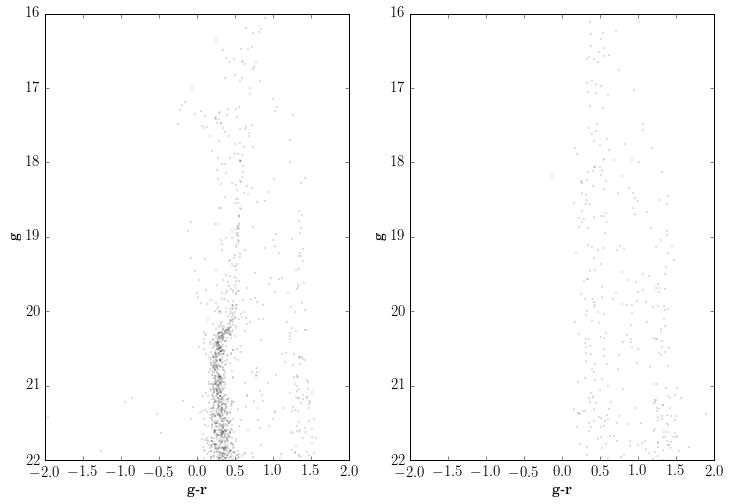

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))

GC_gr = select_GC['dered_g'] - select_GC['dered_r']
GC_g = select_GC['dered_g']

BG_gr = select_bg['dered_g'] - select_bg['dered_r']
BG_g = select_bg['dered_g']

ax[0].scatter(GC_gr, GC_g, marker='.', s=0.1)
ax[1].scatter(BG_gr, BG_g, marker='.', s=0.1)

ax[0].set_ylim(22,16)
ax[1].set_ylim(22,16)

ax[0].set_xlim(-2,2)
ax[1].set_xlim(-2,2)

ax[0].set_xlabel('g-r')
ax[1].set_xlabel('g-r')

ax[0].set_ylabel('g')
ax[1].set_ylabel('g')

plt.show()

We see a very distinct population in the color magnitude diagram for the object, while there is no such correlation for the back ground slice.

**6. Identify a region in $g-r$ vs $g$ plot where the difference between the two plots appears greatest. From your original sample, select stars only present in that *color-magnitude* box, and plot them in $ra$ vs $dec$ scatter plot. Do you notice anything interesting?**

In [22]:
# g-r from 0 to 0.75, g from 22-19

g = t2['dered_g']
r = t2['dered_r']

gr = g - r

color_select1 = t2[(gr < 0.7) & (gr > 0.1) & (g < 22) & (g > 20)]

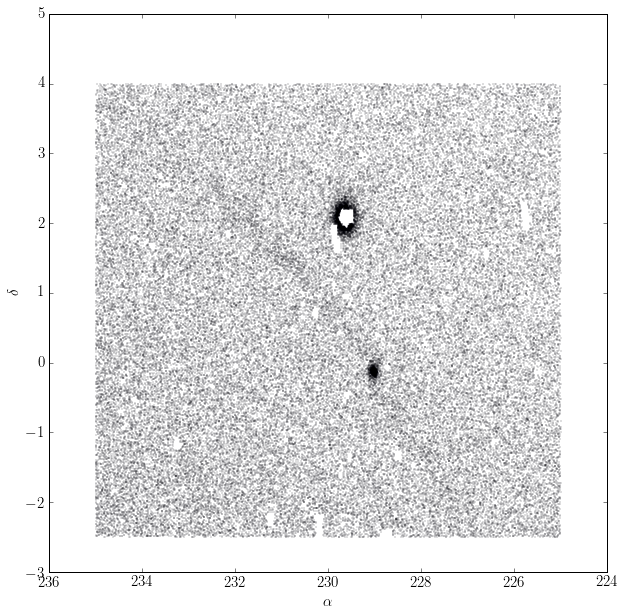

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(color_select1['ra'], color_select1['dec'], marker='.', s=0.1)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')
ax.invert_xaxis()

After making the color selections, we can see the stream much more clearly. It appears to be a globular cluster being stripped the galaxy. 

**7. Extra credit: how would you make the determination of the $g-r$ vs $g$ selection box more quantitative?**

You could fit a contour map on the color magnitude diagram and only select those stars lying within say $1\sigma$ of the contour?

## Problem 2: Importing data into the Large Survey Database

Tasks
-----
* **Install the Large Survey Database (see Lecture #3 for instructions)**

Im going to run this the desktop to access the lsd there.

In [24]:
! conda config --add channels http://www.astro.washington.edu/users/mjuric/conda

Skipping channels: http://www.astro.washington.edu/users/mjuric/conda, item already exists


In [25]:
from lsd import DB
from lsd.bounds import beam, rectangle
import os

In [26]:
os.environ["LSD_DB"] = "/astro/apps6/opt/lsddb"

In [27]:
! lsd-query --version

Large Survey Database, version 


Need to make sure our environment variables are set correctly.

In [28]:
os.environ['NWORKERS'] = '8'
os.environ['LSD_DB'] = '/astro/apps6/opt/lsddb/'
os.environ['LSD_CACHEDIR'] = '/astro/users/mwilde/tempdir/'
os.environ['LSD_TEMPDIR'] = '/astro/users/mwilde/tempdir/'

# add the path to my local copy of lsddb in case we need it
os.environ['LSD_DB'] = os.environ['HOME'] + '/lsddb:/astro/apps6/opt/lsddb'

In [29]:
!ls -l /astro/apps6/opt/lsddb/

total 0
drwxrwsr-x 3 mjuric astro       22 Feb  2  2015 galex_gr5
drwxrwsrwx 4 mjuric astro-apps6 85 Jan 28 01:17 sdss
drwxrwsr-x 3 mjuric astro-apps6 36 Feb  4 11:38 twomass
drwxrwsr-x 3 mjuric astro-apps6 36 Jan 28 14:37 usnob


In [30]:
# This is a bit of a hack -- we use the fact that we know that lsd-query will be installed in $LSD_DIR/bin/lsd-query
lq = ! dirname $(dirname $(which lsd-query))
LSD_DIR = lq[0]
print LSD_DIR



/astro/apps6/opt/anaconda2.4


In [31]:
print os.environ['NWORKERS']
print os.environ['LSD_DB']
print os.environ['LSD_CACHEDIR']
print os.environ['LSD_TEMPDIR']

8
/astro/users/mwilde/lsddb:/astro/apps6/opt/lsddb
/astro/users/mwilde/tempdir/
/astro/users/mwilde/tempdir/


* **Read about the [data contained in sweep files](http://dr12.sdss3.org/datamodel/files/PHOTO_SWEEP/RERUN/calibObj.html) for stars. Write a corresponding YAML LSD schema file. Make sure it consists of (at least) four tablets: basic quantities, photometry, image, resolve and calibration quantities, and the 2MASS match information. Create an LSD table with that schema.**

In [32]:
! cat mysdss_2mass.yaml

# Schema for SDSS star sweep run 94 table
# Has basic quantities, photometry, image, resolve, and calibration and 2MASS match info
filters: {complevel: 5, complib: blosc}
schema:
  common:
    primary_key: sdss_id
    spatial_keys: [RA, DEC]
    columns:
    - [sdss_id, u8]
    - [RA, f8]
    - [DEC, f8]
    - [RUN, i2]
    - [RERUN, a3]
    - [CAMCOL, u8]
    - [FIELD, i2]
    - [ID, i2]
    - [OBJC_TYPE, i4]
    - [OBJC_FLAGS, i4]
    - [OBJC_FLAGS2, i4]
    - [OBJC_ROWC, f4]
    - [ROWVDEG, f4]
    - [ROWVDEGERR, f4]
    - [COLVDEG, f4]
    - [COLVDEGERR, f4]
    - [ROWC, 5f4]
    - [COLC, 5f4]
    - [M_RR_CC, 5f4]
    - [M_RR_CC_PSF, 5f4]
    - [FLAGS, 5i4]
    - [FLAGS2, 5i4]
    - [PSP_STATUS, 5i4]
  photometry:
    columns:
    - [EXTINCTION, 5f4]
    - [SKYFLUX, 5f4]
    - [PSFFLUX, 5f4]
    - [PSFFLUX_IVAR, 5f4]
    - [FIBERFLUX, 5f4]
    - [FIBERFLUX_IVAR, 5f4]
    - [FIBER2FLUX, 5f4]
    - [FIBER2FLUX_IVAR, 5f4]
    - [MODELFLUX, 5f4]
    - [MODELFLUX_IVAR, 5f4]
    - [CMODE

Create the table in LSD

In [33]:
! lsd-admin create table --schema=mysdss_2mass.yaml mw_sdss --drop-existing

Table 'mw_sdss' dropped.

-------- committing 20160225044239.998760 [mw_sdss] ---------
[mw_sdss] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.19 sec
[mw_sdss] Updating neighbors: Already up to date.
[mw_sdss] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.14 sec
[mw_sdss] Updating stats: [0 el.]>  0.00 sec
[mw_sdss] Marking tablets read-only...
----------- success 20160225044239.998760 [mw_sdss] ---------

Table 'mw_sdss' created.


Just to check and see where my table was created:

In [34]:
!ls -l /astro/users/mwilde/lsddb/

total 0
drwxrwxr-x 3 mwilde mwilde 22 Feb 24 20:42 mw_sdss
drwxrwxr-x 3 mwilde mwilde 22 Feb  9 16:45 sdss_sample


* **Download all files belonging to run 94, from http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/. Use `lsd-import` to import these files.**

In [35]:
! lsd-import fits mw_sdss ../../../hw1data/calibObj-000094-*-star.fits 

Importing from 6 pieces:
  ===> Imported ../../../hw1data/calibObj-000094-1-star.fits                           [1/6, 16.67%] + 133515/133515     133515 (0/2 min.)
  ===> Imported ../../../hw1data/calibObj-000094-5-star.fits                           [2/6, 33.33%] + 136292/136292     269807 (0/1 min.)
  ===> Imported ../../../hw1data/calibObj-000094-6-star.fits                           [3/6, 50.00%] + 138113/138113     407920 (0/1 min.)
  ===> Imported ../../../hw1data/calibObj-000094-2-star.fits                           [4/6, 66.67%] + 155355/155355     563275 (0/0 min.)
  ===> Imported ../../../hw1data/calibObj-000094-4-star.fits                           [5/6, 83.33%] + 130027/130027     693302 (0/0 min.)
  ===> Imported ../../../hw1data/calibObj-000094-3-star.fits                           [6/6, 100.00%] + 124832/124832     818134 (0/0 min.)
done

-------- committing 20160225044242.632024 [mw_sdss] ---------
[mw_sdss] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.27 

* **Use `lsd-footprint` to compute the footprint of the run, and plot the result.**

In [36]:
! echo $LSD_DB

/astro/users/mwilde/lsddb:/astro/apps6/opt/lsddb


In [37]:
! ls /astro/users/mwilde/lsddb

mw_sdss  sdss_sample


In [38]:
! lsd-footprint --db=/astro/users/mwilde/lsddb/ mw_sdss run94_foot.fit

 [48 el.]::::::::::::::::::::>  0.44 sec
Objects: 818134.0


In [3]:
from astropy.io import fits

In [4]:
data = fits.getdata('run94_foot.fit')

Plot the entire foot print. Whys is it in this form? why is there no information of Ra and Dec?

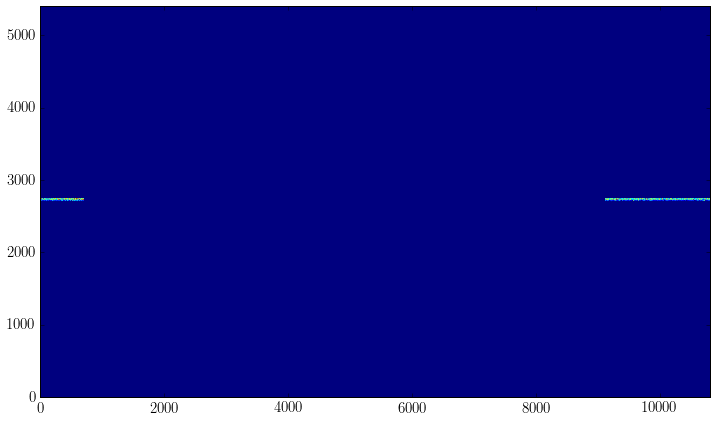

In [43]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(data, aspect='auto', vmin=0, vmax=20)
ax.invert_yaxis()

Zoom to see more detail

(2665, 2745)

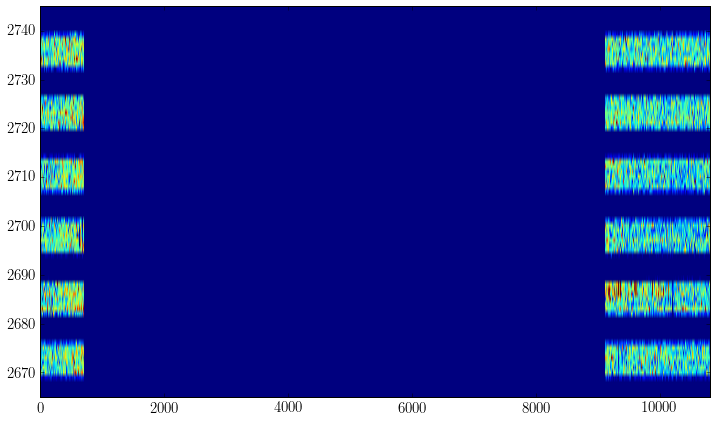

In [44]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(data, aspect='auto', vmin=0, vmax=20)
ax.invert_yaxis()
# ax.set_ylim(2650,2750)
#ax.set_xlim([0,750])
ax.set_ylim([2665,2745])

can use `numpy.roll` to put the data together...

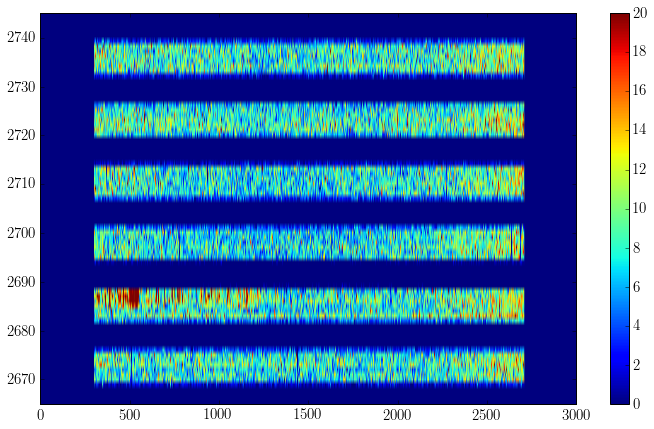

In [45]:
fig, ax = plt.subplots(figsize=(12, 7))
im = ax.imshow(np.roll(data, 2000 , axis=1), aspect='auto', vmin=0, vmax=20)
ax.invert_yaxis()
# ax.set_ylim(2650,2750)
ax.set_xlim(0, 3000)
ax.set_ylim(2665,2745)
fig.colorbar(im)

### If we could use install the WCSAxes package, could display with WCS info...

See:

http://wcsaxes.readthedocs.org/en/latest/installation.html

http://docs.astropy.org/en/stable/wcs/

In [5]:
from astropy.wcs import WCS
hdu = fits.open('run94_foot.fits')[0]

wcs = WCS(hdu.header)

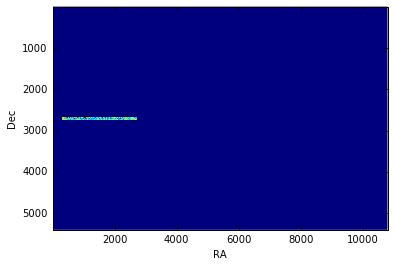

In [7]:
fig = plt.figure()
fig.add_subplot(111, projection=wcs)
plt.imshow(np.roll(hdu.data, 2000 , axis=1), aspect='auto', vmin=0, vmax=20)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [13]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS    : 10800 5401

Except there is no WCS information....